# **SIN 393 – Introduction to Computer Vision (2023)**

# Lecture 04 - Convolutional Neural Networks (Part 4)

Prof. João Fernando Mari ([*joaofmari.github.io*](https://joaofmari.github.io/))

---
* Customized Dataset class
    * Dataset splitting using Scikit-learn. 
    * Access the path to the images in validation and test sets.
    * Data augmentation.

## Mounting Google Drive
---

* Caso esteja executanto no Google Colab, não esquecer de habilitar o acesso à GPU.
    * Editar >> Configurações de notebook >> Acelerador de hardware
    * Selecione GPU
    * OK
* Após o uso, desabilitar o acesso.

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

# DEBUG
print(IN_COLAB)

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

False


## Importing the required libraries
---


In [2]:
import os
import random
import time
import platform

import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing, metrics, model_selection
from skimage import io
from PIL import Image

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.optim import lr_scheduler 
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, models, datasets, utils

## Settings for reproducibility
---
* Operações envolvendo Redes Neurais Convolucionais utilizam números aleatórios.
* Ao repetir um experimento várias vezes, os resultados podem apresentar alguma pequena variação, mesmo utilizando os mesmos dados, modelos e hiperparâmetros. 
* Muitas vezes é interessante fixar as sementes dos geradores de números aleatórios para reproduzir os resultados em diferentes execuções dos experimentos.


In [3]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

## Checking GPU Access
---


In [4]:
# Verifica se a GPU está disponível
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('\nDevice: {0}'.format(DEVICE))


Device: cuda


In [5]:
!nvidia-smi

Tue Oct  3 23:57:25 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.113.01             Driver Version: 535.113.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050 Ti     Off | 00000000:01:00.0 Off |                  N/A |
| 49%   36C    P5              N/A /  75W |   1684MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## The dataset
---
* Flower dataset
    * https://www.kaggle.com/datasets/alxmamaev/flowers-recognition
    * 4242 imagens de flores
    * 5 classes
 * Folder hierarch:
    * [flowers]
        * [daisy]
        * [dandelion]
        * [rose]
        * [suinflower]
        * [tulip]

In [6]:
if IN_COLAB:
    ds_path = '/content/drive/My Drive/Data/flowers-recognition/flowers/'
else:
    ### ds_path = 'data/flowers-recognition/flowers/'
    ds_path = '/home/joao/Datasets/flowers-recognition/flowers/'

EXP_PATH = './exp-02-4/'
if not os.path.exists(EXP_PATH):
    os.makedirs(EXP_PATH)

In [7]:
# Nomes das classes
class_names = os.listdir(ds_path)
## TODO: Garantir que apenas pastas serão listadas.

# Número de classes. Equivale ao número de subpastas na pasta do dataset.
num_classes = len(class_names)

## Setting hyperparameters and configurations
---

In [8]:
# Tamanho do lote (mini-batch)
batch_size = 64
# Taxa de aprendizado
lr = 0.0001
# Mommentum
mm = 0.9
# Número de épocas
epochs = 50 # Usar um valor pequeno durante o desenvolvimento, 2 por exemplo. 
# Step size
ss = 10

In [9]:
ARCH_NAME = 'alexnet' # 'simplenet', 'alexnet', 'resnet18', ...

## Preparando o conjunto de dados
---

### Customized Dataset class

In [10]:
class FlowersDataset(Dataset):

    def __init__(self, path_list, label_list, transforms=None):
        self.path_list = path_list
        self.label_list = label_list
        self.transforms = transforms

    def __len__(self):
        return len(self.path_list)

    def __getitem__(self, idx):
        path = self.path_list[idx]
        ### image = io.imread(self.path_list[idx])
        image = Image.open(self.path_list[idx]) 

        label = self.label_list[idx]

        if self.transforms:
            image = self.transforms(image)

        return (image, label, path)       

In [11]:
# Treinamento. Com data augmentation
data_transforms_train = transforms.Compose([# DATA AUGMENTATION
                                            transforms.RandomHorizontalFlip(p=0.5),
                                            transforms.RandomRotation(degrees=15),
                                            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                                            transforms.GaussianBlur(kernel_size=3),
                                            # Resimensiona as imagens para o tamanho da entrada da rede.
                                            ### transforms.Resize(size=(224, 224)),
                                            transforms.RandomResizedCrop(size=224),
                                            transforms.ToTensor(),
                                            # Normalização. Média e desvio padrão do ImageNet. 
                                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
                                           ])

data_transforms_test = transforms.Compose([# Resimensiona as imagens para o tamanho da entrada da rede.
                                           ### transforms.Resize(size=(224, 224)),
                                           transforms.CenterCrop(size=224),
                                           transforms.ToTensor(),
                                           # Média e desvio padrão do ImageNet. 
                                           transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
                                          ])     


In [12]:
# Lista com todos os caminhos para as imagens e respectivos rótulos
path_list = []
label_list = []

# Itera ao longo das pastas das classes
for class_ in class_names:
    # Lista ordenada dos arquivos (imagens) em cada pasta
    path_list_ = os.listdir(os.path.join(ds_path, class_))
    path_list_.sort()

    # Itera ao longo dos arquivos na pasta atual (classe)
    for path_image in path_list_:
        file_path = os.path.join(ds_path, class_, path_image)
        path_list.append(file_path)
        label_list.append(class_)

In [13]:
TEST_SIZE = 0.2
VAL_SIZE = 0.2
TRAIN_SIZE = 1. - TEST_SIZE - VAL_SIZE

# Dictionary of index labels
le = preprocessing.LabelEncoder()
le.fit(class_names)
label_list_idx = le.transform(label_list)

# Separa TEST_SIZE do conjuto de completo para TESTES. 1. - TEST_SIZE para treinamento 1.
X_train_, X_test, y_train_, y_test = model_selection.train_test_split(path_list, 
                                                                      label_list_idx, 
                                                                      test_size=TEST_SIZE, 
                                                                      stratify=label_list_idx,
                                                                      random_state=42)

# Separa VAL_SIZE do conjuto de completo para TESTES. (VAL_SIZE / TRAIN_SIZE) do conjunto de treinamento 1.
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train_, 
                                                                  y_train_, 
                                                                  test_size=(VAL_SIZE / TRAIN_SIZE), 
                                                                  stratify=y_train_,
                                                                  random_state=42)

# Construindo os datasets usando a classe Dataset personalizado.
train_dataset = FlowersDataset(X_train, y_train, transforms=data_transforms_train)
val_dataset = FlowersDataset(X_val, y_val, transforms=data_transforms_test)
test_dataset = FlowersDataset(X_test, y_test, transforms=data_transforms_test)

# Número de imagens em cada dataset
train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)

# DEBUG
print(train_size)
print(val_size)
print(test_size)

2302
1151
864


In [14]:
# Definindo os dataloaders
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset, shuffle=True, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, shuffle=False, batch_size=batch_size)

### Visualizing a batch of images

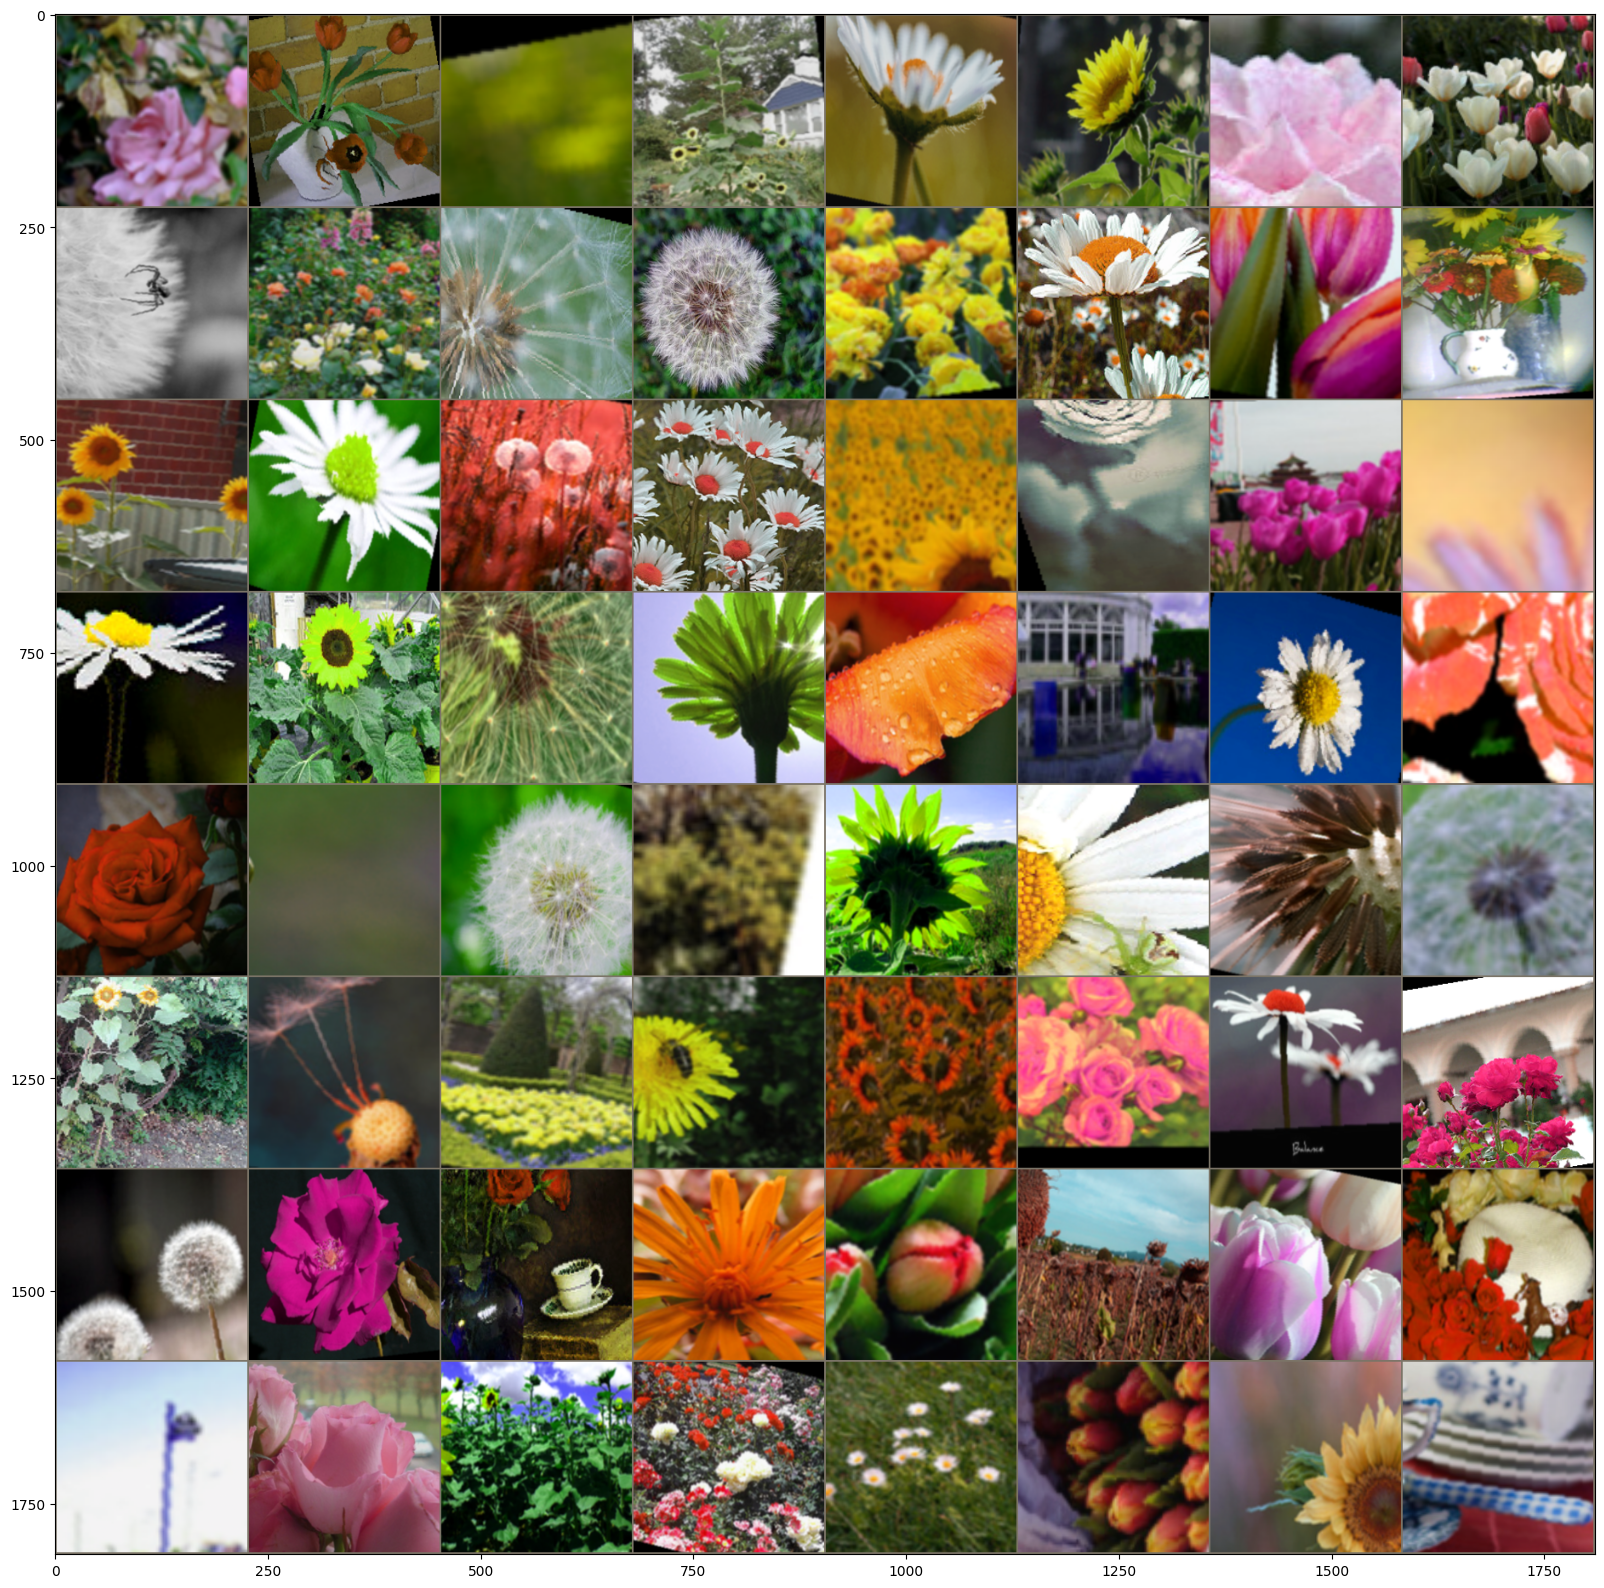

In [15]:
def show_transformed_image(image):
    # Unnormalize the channels. mageNet weights
    for t, m, s in zip(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]):        
        t.mul_(s).add_(m)

    np_image = image.numpy()

    plt.figure(figsize=(20, 20))
    plt.imshow(np.transpose(np_image, (1, 2, 0)))

# Visualizar 'batch_size' imagens
dataloader_vis = torch.utils.data.DataLoader(dataset=train_dataset, shuffle=True, batch_size=64)
items = iter(dataloader_vis)
image, label, *_ = next(items)

show_transformed_image(utils.make_grid(image))

plt.savefig(os.path.join(EXP_PATH, 'sample_batch.pdf')) 

## A simple CNN architecture
---

In [16]:
class Net(nn.Module):
    """
    Considering each image having 224 x 224 x 3:
    
    Input [3, 224, 224] 
    Conv1(3, 6, 5) [6, 220, 220] 
    Pool(2, 2) 16, 110, 110]
    Conv2(6, 16, 5) [16, 106, 106]
    Pool(2, 2) [16, 53, 53]
    Flatten [44944] (16 x 53 x 53 = 44944)
    Fc1 [120]
    Fc2 [84]
    Fc3 [10]
    """
    def __init__(self, in_channels, num_classes):
        """
        torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, 
                        dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
        """
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(in_features=16 * 53 * 53, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=num_classes)

    def forward(self, x):
        # conv1(x): Input: [224, 224, 3]. Output: [220, 220, 6].
        x = self.conv1(x)
        x = F.relu(x)
        # pool: Input: [220, 220, 6], Output: [110, 110, 6]
        x = self.pool(x)
        # conv2: Input: [110, 110, 6]. Output: [106, 106, 16].
        x = self.conv2(x)
        x = F.relu(x)
        # pool: Input: [106, 106, 16], Output: [53, 53, 16]
        x = self.pool(x)
        # flatten: Input: [53, 53, 16]. Output: [44944]
        x = torch.flatten(x, 1) 
        # fc1: Input: [44944]. Output: [120]
        x = self.fc1(x)
        x = F.relu(x)
        # fc2: Input: [120]. Output: [84]
        x = self.fc2(x)
        x = F.relu(x)
        # fc3: Input: [80]. Output: [num_classes]
        x = self.fc3(x)
        
        return x

## Using a pretrainned model (fine-tunning)
---


### Selecting the model

In [17]:
if ARCH_NAME == 'simplenet':
    # Simple net
    model = Net(224, num_classes)

elif ARCH_NAME == 'alexnet':
    # Pretrainned
    model = models.alexnet(weights='AlexNet_Weights.DEFAULT')
    ### model = models.alexnet(weights='AlexNet_Weights.IMAGENET1K_V1')
    # Altera o número de neurônios na cadama de saída.
    num_ftrs = model.classifier[6].in_features
    ### model.classifier[6] = nn.Linear(4096, num_classes)
    model.classifier[6] = nn.Linear(num_ftrs, num_classes)   

elif ARCH_NAME == 'resnet18':
    model = models.resnet18(weights='ResNet18_Weights.DEFAULT')
    ### model = models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
    # Altera o número de neurônios na cadama de saída.
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

# Include more architectures...
### elif ARCH_NAME == ...

In [18]:
# Envia o modelo para a GPU
if DEVICE.type == 'cuda':
    model = model.cuda() # Cuda
    
# Imprime o modelo
print(str(model))

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Loss function and optimizer

* https://pytorch.org/docs/stable/optim.html

In [19]:
# Função de perda
criterion = nn.CrossEntropyLoss()

# Otimizador - SGD
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=mm)

# Adjust learning rate
scheduler = lr_scheduler.StepLR(optimizer, step_size=ss)

## Training the model
---

In [20]:
# Tempo total do treinamento (treinamento e validação)
time_total_start = time.time()

# Lista das perdas (loss) e acurácias (accuracy) de trino para cada época.
train_loss_list = []
train_acc_list = []

# Lista das perdas (loss) e acurácias (accuracy) de validação para cada época.
val_loss_list = []
val_acc_list = []

# Learning rate list
lr_list = []

for epoch in range(epochs):
    # TREINAMENTO
    # =========================================================================
    # Inicia contagem de tempo da época
    time_epoch_start = time.time()

    # Habilita o modelo para o modo de treino 
    model.train() 

    # Perda (loss) nesta época
    loss_epoch_train = 0.0    
    # Amostras classificadas corretamente nesta época
    hits_epoch_train = 0  

    # Iterate along the batches of the TRAINING SET
    for inputs, labels, *_ in train_dataloader:

        if DEVICE.type == 'cuda':
            inputs = inputs.to(DEVICE) 
            labels = labels.to(DEVICE) 

        # Zera os parametros do gradiente
        optimizer.zero_grad() 

        # FORWARD
        # ------>
        # Habilita cálculo do gradiente
        torch.set_grad_enabled(True) 

        # Saída do modelo para o lote
        outputs = model(inputs) 

        #  Tomar o maior valor de 'outputs' como predição.
        preds = torch.argmax(outputs, dim=1).float() 

        # Calcula a perda (loss)
        loss = criterion(outputs, labels)

        # BACKWARD
        # <-------
        loss.backward() 

        # Atualiza os parâmetros da rede
        optimizer.step()

        # Atualiza a perda da época
        loss_epoch_train += float(loss.item()) * inputs.size(0) 

        # Atualiza o número de amostras classificadas corretamente na época.
        hits_epoch_train += torch.sum(preds == labels.data) 

    # Perda desta época
    train_loss = loss_epoch_train / train_size
    # Acurácia desta época
    train_acc = float(hits_epoch_train.double() / train_size)

    # Store loss and accuracy in lists
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    # VALIDAÇÃO
    # =========================================================================
    model.eval() 

    # Epoch validation loss
    loss_epoch_val = 0.0 #
    # Num hits for this epoch
    hits_epoch_val = 0 
    
    # Iterate along the batches of the VALIDATION SET
    for inputs, labels, *_ in val_dataloader:

        if DEVICE.type == 'cuda':
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

        # Zera os parametros do gradiente
        optimizer.zero_grad() 

        # Desabilita o cálculo do gradiente durante a validação.
        torch.set_grad_enabled(False) 

        # Gero um tensor cujas linhas representam o tamanho do "batch" do input
        outputs = model(inputs) 

        # Retorna o maior valor como predição.
        preds = torch.argmax(outputs, dim=1).float()

        # Calcula a perda (loss)
        loss = criterion(outputs, labels) 

        # Atualiza a perda da época
        loss_epoch_val += float(loss.item()) * inputs.size(0)
        # Atualiza os acertos da época
        hits_epoch_val += torch.sum(preds == labels.data)

    # Ajusta o learning rate
    scheduler.step() 

    # Store the learning rate
    lr_epoch = optimizer.param_groups[0]['lr']
    lr_list.append(lr_epoch)
        
    # Perda e acuracia do conjunto de validacao para esta época
    val_loss = loss_epoch_val / val_size
    val_acc = float(hits_epoch_val.double() / val_size)

    # Store val loss and accuracy in lists
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    # Tempo total desta época
    time_epoch = time.time() - time_epoch_start
    
    # PRINTING
    # --------
    print(f'Epoch {epoch}/{ epochs - 1} - TRAIN Loss: {train_loss:.4f} TRAIN Acc: {train_acc:.4f} - VAL. Loss: {val_loss:.4f} VAL. Acc: {val_acc:.4f} ({time_epoch:.4f} seconds)')

# Tempo total do treinamento
time_total_train = time.time() - time_total_start

# PRINTING
print(f'\nTreinamento finalizado. ({int(time_total_train // 60)}m and {int(time_total_train % 60)}s)')

Epoch 0/49 - TRAIN Loss: 1.4111 TRAIN Acc: 0.4170 - VAL. Loss: 0.9093 VAL. Acc: 0.6646 (50.8188 seconds)
Epoch 1/49 - TRAIN Loss: 0.9100 TRAIN Acc: 0.6607 - VAL. Loss: 0.6951 VAL. Acc: 0.7307 (50.4509 seconds)
Epoch 2/49 - TRAIN Loss: 0.7652 TRAIN Acc: 0.7202 - VAL. Loss: 0.6323 VAL. Acc: 0.7593 (50.2840 seconds)
Epoch 3/49 - TRAIN Loss: 0.6985 TRAIN Acc: 0.7424 - VAL. Loss: 0.5821 VAL. Acc: 0.7802 (50.2343 seconds)
Epoch 4/49 - TRAIN Loss: 0.6489 TRAIN Acc: 0.7615 - VAL. Loss: 0.5694 VAL. Acc: 0.7897 (50.8177 seconds)
Epoch 5/49 - TRAIN Loss: 0.6157 TRAIN Acc: 0.7732 - VAL. Loss: 0.5590 VAL. Acc: 0.7880 (50.9604 seconds)
Epoch 6/49 - TRAIN Loss: 0.6301 TRAIN Acc: 0.7485 - VAL. Loss: 0.5500 VAL. Acc: 0.7924 (50.8203 seconds)
Epoch 7/49 - TRAIN Loss: 0.5775 TRAIN Acc: 0.7806 - VAL. Loss: 0.5287 VAL. Acc: 0.8045 (50.3631 seconds)
Epoch 8/49 - TRAIN Loss: 0.5936 TRAIN Acc: 0.7763 - VAL. Loss: 0.5302 VAL. Acc: 0.8080 (50.4511 seconds)
Epoch 9/49 - TRAIN Loss: 0.5811 TRAIN Acc: 0.7911 - VAL

## Saving (and loading) the trained model

In [21]:
torch.save(model, os.path.join(EXP_PATH, 'model.pth'))

In [22]:
# Para carregar o modelo
### model = torch.load(os.path.join(EXP_PATH, 'model.pth'))

## Analyzing the training
---

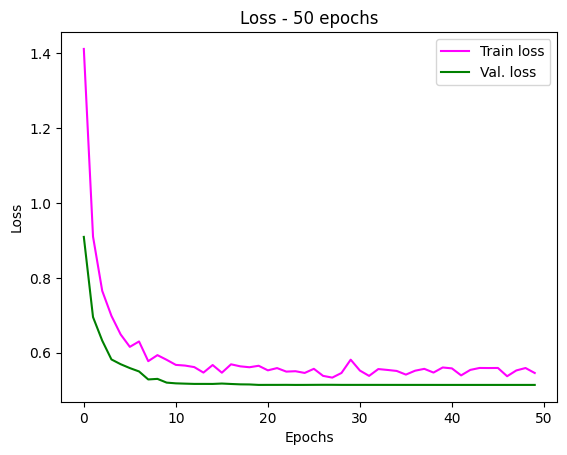

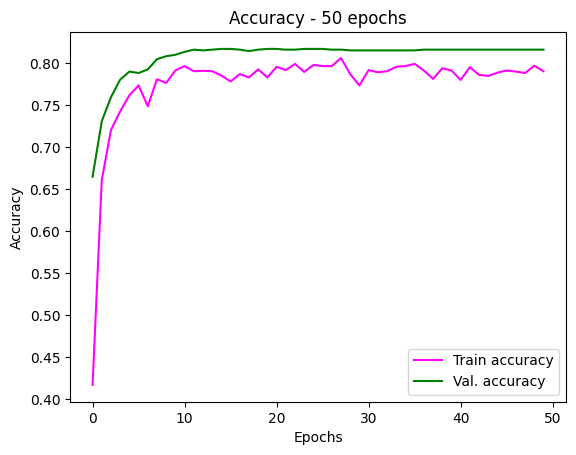

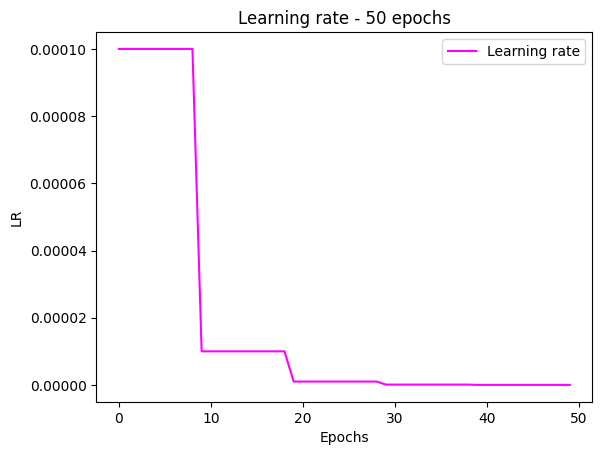

In [23]:
# Lista com os indices das épocas. [0, 1, ... num_epochs - 1]
epochs_list = []
for i in range(len(train_loss_list)):
    epochs_list.append(i)

# Plot - Loss 
plt.figure()
plt.title(f'Loss - {epochs} epochs')
plt.plot(epochs_list, train_loss_list, c='magenta', ls='-', label='Train loss', fillstyle='none')
plt.plot(epochs_list, val_loss_list, c='green', ls='-', label='Val. loss', fillstyle='none')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.savefig(os.path.join(EXP_PATH, 'loss_history.pdf')) 

# Plot - Accuracy
plt.figure()
plt.title(f'Accuracy - {epochs} epochs')
plt.plot(epochs_list, train_acc_list, c='magenta' ,ls='-', label='Train accuracy', fillstyle='none')
plt.plot(epochs_list, val_acc_list, c='green' ,ls='-', label='Val. accuracy', fillstyle='none')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.savefig(os.path.join(EXP_PATH, 'acc_history.pdf')) 

# Plot - LR
plt.figure()
plt.title(f'Learning rate - {epochs} epochs')
plt.plot(epochs_list, lr_list, c='magenta' ,ls='-', label='Learning rate', fillstyle='none')
plt.xlabel('Epochs')
plt.ylabel('LR')
plt.legend(loc='best')
plt.savefig(os.path.join(EXP_PATH, 'lr_history.pdf')) 

## Evaluating the model over the test set
---

In [24]:
# Lista com as classes reais e classes preditas
true_test_list = []
pred_test_list = []
# Lista com as probabilidades
prob_test_list = []
# lista com os caminhos para as imagens
path_test_list = []

# Iterate along the batches of the TEST SET
for i, (img_list, label_list, path_list) in enumerate(test_dataloader):

    if DEVICE.type == 'cuda':
        img_list = img_list.to(DEVICE)
        label_list = label_list.to(DEVICE)

    # Desabilita o cálculo do gradiente durante validação e testes.
    torch.set_grad_enabled(False) 

    # -----> FORWARD
    # Saída do modelo
    outputs = model(img_list)

    # Predição
    preds = torch.argmax(outputs, dim=1)

    # Calcula probabilidades 
    # https://discuss.pytorch.org/t/obtain-probabilities-from-cross-entropy-loss/157259
    outputs_prob = nn.functional.softmax(outputs, dim=1)
    ### prob_test_batch = np.asarray(outputs_prob.cpu())
    prob_test_batch = list(outputs_prob.cpu())

    # Classes reais (true) e classes preditas (pred) para este lote.
    if DEVICE.type == 'cuda':
        true_test_batch = list(label_list.cpu())
        pred_test_batch = list(preds.cpu())
    else:
        true_test_batch = list(label_list)
        pred_test_batch = list(preds)
        
    # Append batch results to the lists
    true_test_list += true_test_batch
    pred_test_list += pred_test_batch
    
    prob_test_list += prob_test_batch
    path_test_list += path_list

## Confusion matrix and classification report
---

In [25]:
# Confusion matrix
conf_mat_test = metrics.confusion_matrix(true_test_list, pred_test_list)
print('\nConfusion matrix (test set)')
print(conf_mat_test)

# Classification report - Scikit-learn
class_rep_test = metrics.classification_report(true_test_list, 
                                               pred_test_list, 
                                               target_names=class_names, 
                                               digits=4,
                                               zero_division=0)
print('\nClass. report (test set)')
print(class_rep_test)

# Accuracy
acc_test = metrics.accuracy_score(true_test_list, pred_test_list)
print('\n\nValidation Acc.: {:.4f}'.format(acc_test))


Confusion matrix (test set)
[[128  11   2   8   4]
 [  4 191   0  14   1]
 [ 10   7 113   5  22]
 [  5   3   3 133   3]
 [  2   4  14  14 163]]

Class. report (test set)
              precision    recall  f1-score   support

   sunflower     0.8591    0.8366    0.8477       153
       tulip     0.8843    0.9095    0.8967       210
       daisy     0.8561    0.7197    0.7820       157
        rose     0.7644    0.9048    0.8287       147
   dandelion     0.8446    0.8274    0.8359       197

    accuracy                         0.8426       864
   macro avg     0.8417    0.8396    0.8382       864
weighted avg     0.8452    0.8426    0.8417       864



Validation Acc.: 0.8426


In [26]:
class_rep_path = os.path.join(EXP_PATH, 'classification_report_test.txt')
file_rep = open(class_rep_path, 'w')

file_rep.write('\nTEST. SET:')
file_rep.write('\n\nConfusion matrix:\n')
file_rep.write(str(conf_mat_test))
file_rep.write('\n\nClassification report:\n')
file_rep.write(class_rep_test)
file_rep.write('\n\nAccuracy:\t' + str(acc_test))

file_rep.close()

### Detailed classification report

In [27]:
# Conjunto de testes
class_rep_path = os.path.join(EXP_PATH, 'class_report_detailed_test.csv')
file_rep = open(class_rep_path, 'w')

print('\n#\tImage path\tTarget\tPrediction\tCorrect?', end='')
file_rep.write('\n#;Image path;Target;Prediction;Correct?')

for class_name in class_names:
    print(f'\t {class_name}', end='')
    file_rep.write(f'\t {class_name}')

for i, (path, true, pred, probs) in enumerate(zip(path_test_list, true_test_list, pred_test_list, prob_test_list)):
    print(f'\n{i} \t {path} \t {true} \t {pred} \t {true==pred}', end='')
    file_rep.write(f'\n{i};{path};{true};{pred};{true==pred}')

    for prob in probs:
        print(f'\t{prob:.4f}', end='')
        file_rep.write(f'\t{prob:.4f}')

file_details.close()


#	Image path	Target	Prediction	Correct?	 sunflower	 tulip	 daisy	 rose	 dandelion
0 	 /home/joao/Datasets/flowers-recognition/flowers/sunflower/14925398301_55a180f919_n.jpg 	 3 	 3 	 True	0.0004	0.0014	0.0000	0.9983	0.0000
1 	 /home/joao/Datasets/flowers-recognition/flowers/daisy/5435522104_1d6a61b431_n.jpg 	 0 	 0 	 True	0.9997	0.0001	0.0000	0.0002	0.0000
2 	 /home/joao/Datasets/flowers-recognition/flowers/daisy/14330343061_99478302d4_m.jpg 	 0 	 0 	 True	0.9959	0.0021	0.0002	0.0018	0.0000
3 	 /home/joao/Datasets/flowers-recognition/flowers/rose/323872063_7264e7e018_m.jpg 	 2 	 2 	 True	0.0001	0.0000	0.9581	0.0000	0.0417
4 	 /home/joao/Datasets/flowers-recognition/flowers/tulip/18270448366_d5676dec64_z.jpg 	 4 	 4 	 True	0.0001	0.0000	0.0000	0.0009	0.9989
5 	 /home/joao/Datasets/flowers-recognition/flowers/tulip/20692409652_25da3e5839_n.jpg 	 4 	 4 	 True	0.0021	0.0003	0.3280	0.0022	0.6674
6 	 /home/joao/Datasets/flowers-recognition/flowers/tulip/7166620850_8a37b95972_n.jpg 	 4 	 4 	

NameError: name 'file_details' is not defined

## Bibliography
---
* PyTorch. Training a Classifier
    * https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
* Microsoft. Train your image classifier model with PyTorch.
    * https://learn.microsoft.com/en-us/windows/ai/windows-ml/tutorials/pytorch-train-model
* Nathan Inkawhich. FINETUNING TORCHVISION MODELS.
    * (Broken link) https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html 
    * (New link) https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/pytorch/finetuning_torchvision_models_tutorial.ipynb#scrollTo=kfl9S6PnhsuC
* Sasank Chilamkurthy. TRANSFER LEARNING FOR COMPUTER VISION TUTORIAL. 
    * https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
* Datasets & DataLoaders
    * https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
* Writing Custom Datasets, DataLoaders and Transforms
    * https://pytorch.org/tutorials/beginner/data_loading_tutorial.html